In a previous notebook, we have shown how to [fit a psychometric curve using pyTorch](https://laurentperrinet.github.io/sciblog/posts/2020-04-08-fitting-a-psychometric-curve-using-pytorch.html). Here, I would like to review some nice properies of the logistic regression model (WORK IN PROGRESS). 

<!-- TEASER_END -->

Let's first initialize the notebook:

# quelques définitions

## initialisation du notebook

Nous allons importer quelques librairies qui seront utilisées pour la manipulation numérique de matrices et l'affichage:

In [1]:
import time
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

## Définition des variables et fonctions

... utiles pour réaliser une classification  de données synthétiques selon une régression logistique

In [2]:
N = 256 # nombre de valeurs de l'entrée
n_classes = 10 # nombre de classes
N_batch = 100 # nombre d'échantillons
seed = 1973

np.random.seed(seed)
W = np.random.randn(N+1, n_classes) # FIXED design matrix of weights (w) according to classes

# Definition de l'évidence (e) 
def evidence(W, X):
    """
    Modèle génératif de l'évidence:
    W[:-1, :] = N poids pour n_classes
    W[-1, :] = 1 biais pour chaque classe
    """
    e = (X @ W[:-1, :]) + W[-1, :] 
    return e

# Transformation de l'entrée (e) en probabilité (p) selon une courbe de regression logistique
def sigmoid(logodds):
    return 1 / (1 + np.exp(-logodds))

def get_data(W, seed, N_batch):
    N, n_classes = W.shape[0]-1, W.shape[1]
    np.random.seed(seed)
    # nos entrées (X) : n_batch échantillons comprenant chacun N valeurs
    # tirage de causes aléatoires
    X = np.random.randn(N_batch, N) 
    # modèle génératif: mélange
    p = sigmoid(evidence(W, X))
    # Tirage de Bernoulli : si p > à random => 1, si p < à random = 0 
    y = p > np.random.rand(N_batch, n_classes) # Bernoulli, generate data 
    return X, p, y

In [3]:
X, p, y = get_data(W, seed, N_batch)
e = evidence(W, X)

In [4]:
X, p, y = get_data(W, seed, N_batch) 
X.shape, e.shape, p.shape, y.shape

((100, 256), (100, 10), (100, 10), (100, 10))

Avec __X,p,y = get_data(W, seed, N_batch)__ on appelle la fct get_data, qui appelle la fonction `sigmoid`, qui appelle la fonction evidence afin de nous renvoyer les entrées X (100 entrées, comprenant chacune 256 valeures), les probabilités de classification de ces différentes entrées dans les différentes classes (p), et la classification après tirage de bernoulli (y = succès si p > 0.5, echcec si p < 0.5). Pour visualiser les sorties (p et y) en fonction des entrées (X et e), on les stock dans des arrays. 

## Visualisation des données

Visualisation de p en fonction de e pour une classe :

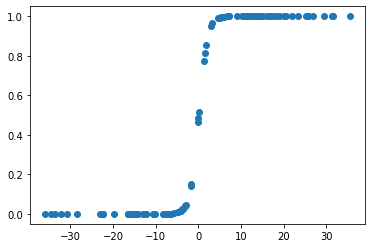

In [5]:
plt.scatter(e[:,1],p[:,1]) 

Visualisation de p en fonction de e pour une classe + de la sortie (tirage de Bernoulli = y) 

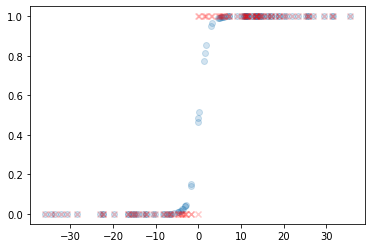

In [6]:
plt.scatter(e[:,1],p[:,1], alpha=.2) #proba de e d'être classifié dans classe 1
plt.scatter(e[:,1],y[:,1], alpha=.2, marker="x", color="red") #Sortie de Bernoulli 

Visualisation de la distribution des probabilités de classification 

(array([432.,  14.,  13.,  11.,   8.,   9.,   8.,  15.,  20., 470.]),
 array([2.91404343e-24, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

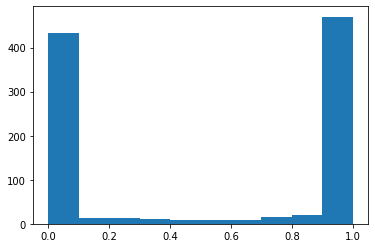

In [7]:
plt.hist(p.ravel(), bins=10)

Visualisation de p en fonction de chaque entrée X + de la sortie y  'permise' par l'ajout des w et biais 

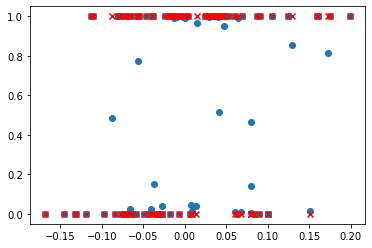

In [8]:
X_1 = np.average(X.reshape(-1, 256), axis=1)
plt.scatter(X_1,p[:,1]) 
plt.scatter(X_1,y[:,1],marker="x", color="red")

... la situation est plus confuse... est-ce quon va arriver à distinguer les différents cas?

# Inversion

## Définition du réseau d'inversion

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# see https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html#pytorch-loss-input-confusion-cheatsheet
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size//the sum of the output will be divided by the number of elements in the output
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output 

class LogisticRegressionModel(torch.nn.Module):
    
    # voir ce que signifie self 
    # voir ce que signifie super 
    
    def __init__(self, N, n_classes, bias=True): # (self, input_dim, output_dim)
        super(LogisticRegressionModel, self).__init__() 
        
        # 1ere couche : self.linear = torch.nn.Linear(input_dim, output_dim, bias=true) bias = true pour apprentissage
        self.linear = torch.nn.Linear(N, n_classes, bias=bias) 
        
        # 2e couche : self.nl = torch.nn.Sigmoid() = ouputs 
        # autre possibilité : self.nl = torch.nn.LogSoftmax(n_classes)
        self.nl = torch.nn.Sigmoid()
    
    # maintenant qu'on a difinit les couches, on 
    # self.nl me donne la sigmoïde de e 
    # X = (N, n_batch) là on est dans 1 batch donc X = 256 = N 
    
    def forward(self, X):
        return self.nl(self.linear(X))

 __init__ permet de définir notre NN, les couches, leur role, la dimention des entrées et sorties
 
On a un réseau composé de deux couches : 
- la première (self.linear) réalise une transformation linéaire de nos entrées X (de dimention N =  256) de sorte à ce que la sortie y = (w*x)+biais = e (de dimention n_classes = 10). Une entrée sera associée aux différentes classes avec un w et un biais associé pour chacune des classes. Après plusieurs batch, on obtiendra plusieurs e pour la même ent alors plusieurs e pour chaque classes.
    
- la deuxième (self.nl) transforme ces sorties (e) pour leur donner une distribution sigmoïde. On obtient ainsi la probabilité de classification de l'entrée X, associée à un poid w et au biais. On aura n_classes sigmoïdes, représentant la probabilité de classification de l'entrée dans chacune des classes en fonction du w et du biais associé. 

La fonction __forward__ permet de construire le réseau en connectant les couches selon un modèle forward : self.nl(self.linear(X))

Par la suite, le réseau va modifier ses paramètres : w et biais de sorte à ce que la classification des X se fasse de la même manière que pendant l'initialisation

-> Pour cela, on demande à notre réseau de calculer la loss function entre la classification réalisée par self.nl(self.linear(X)) et celle réalisée par y 

-> Plus la différence est grande, plus la loss function l'est aussi et plus le réseau va modifier ses paramètres (W et biais) pour classifier de la même façon que pdt l'initialisation 

-> On devrait donc retrouver à la fin des W et des biais similaires entre ceux fixés par nous pendant l'initialisation et ceux déterminés par le réseau pdt l'inversion 


In [10]:
logistic_model = LogisticRegressionModel(N,n_classes) #(input_dim, output_dim)

In [11]:
bias_before_training = logistic_model.linear.bias
w_before_training = logistic_model.linear.weight
#bias_before_training.shape # shape = 10 car 1 biais associé à une classe, pour tous les x 
#w_before_training.shape # shape =  ([10, 256]) car pour chaque classe, on attribue 1 poid à chaque X

## Définition des variables d'apprentissage, d'entrée et de sortie

In [12]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1 # epoch = le nombre de passages dans l'ensemble des données d'entraînement que le réseau a effectués, ici 513 max
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

batch_size = 100
n_classes= 10

X = torch.randn(N_batch, N)
outputs = logistic_model(X)


## Défition des fonctions pour l'apprentissage des w et biais pour classification

In [13]:
def fit_data(X, y, learning_rate=learning_rate,batch_size=batch_size,num_epochs=num_epochs,betas=betas,verbose=False, **kwargs):

    X_0 = torch.Tensor(X[:, None]) # rajoute une dimention de taille 1 : pk ? 
    labels = torch.Tensor(y[:, None]) # remplace les True/False par des 1 et 0, rajoute une dimention de taille 1 : pk ? 
    
    loader = DataLoader(TensorDataset(X_0, labels), batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_batch = X.shape[0] # = 100
    N = X.shape[1] # = 256 
    n_classes = y.shape[1] # = 10
    
    logistic_model = LogisticRegressionModel(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad) # diminue le learning rate petit à petit de sorte à atteindre le minimum de la loss function / Adam utilise une moyenne à décroissance exponentielle des gradients passés afin de fournir une fréquence d'apprentissage adaptative. 
    
    for epoch in range(int(num_epochs)): # on commence à 1 jusq'à 513 epoch, cad qu'il passe par tous les X_ 513 fois
        logistic_model.train()
        losses = [] 
        for X_, labels_ in loader: 
            X_, labels_ = X_.to(device), labels_.to(device)
            outputs = logistic_model(X_)  
            loss = criterion(outputs, labels_) #calcul de la différence entre l'outpul de logistic_model et la classification effectuée pdt l'initialisation (PROBLEME ? on compare des proba à y=true/false)
                                               
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
        
            
            losses.append(loss.item())   

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}") 

    logistic_model.eval()
    X_0, labels = torch.Tensor(X[:, None]), torch.Tensor(y[:, None]) #utile ? 
    outputs = logistic_model(X_0) #utile ? 
    loss = criterion(outputs, labels).item()
    return logistic_model, loss

Dans la fonction __fit_data__ :
- On commence par __définir les variables d'intéret et l'optimizer__. Lors de la définition de l'optimizer, on lui indique __quel paramètre il doit modfier__ pendant l'apprentissage et le learning rate. Ici les paramètres modifiés par l'optimizer sont les poids et biais associés aux entrées pour les différentes classes. L'optimizer Adam va modifier le poid et le biais des différentes classes pour que la classfication des entrées soit similaire à celle obtenue pendant l'initialisation. Pour cela, il fait ........... . La particularité de cet optimizer est qu'il diminue le learning rate en même temps que la différence diminue. Le learning rate correspond au nombre de pas necessaire pour atteindre le minimum de loss function- à approfondir - 

- En suite, __on commence l'entrainement__ à partir des données comprises dans loader (= X_0, labels // équivalent à : N_batch entrées de N valeurs (= X) et N_batch sorties de n_classes valeurs (= y)). Dans un premier temps, on prend les X, on les fait passer dans le logistic_model et on récupère dans outputs les probabilités de classification des N_batch entrées. Ensuite, on compare la classification effectuée par le logistic_model avec celle effectuée dans l'iniitialisation. Le criterion calcule la différence entre les deux par le calcule de la BCE et on stock cette différence dans loss. L'optimizer va modifier les w et biais associés aux entrées pour les différentes classes de sorte à diminuer au plus possible la loss function au cours de différentes iterations. 

- On demande d'imprimer les loss_function toutes les itérations multiples de 32 

- ensuite on passe au __test du logistic_model__ et on renvoit la probabilté de classification des n_batch entrées ainsi que la loss_function après apprentissage des poids et biais optimaux pour que la classification se fasse comme dans l'initialisation. 

__On devrait ainsi obtenir des poids et biais similaires à ceux définis dans l'inialisation : C'est l'inversion__ 

On appelle la fonction get_data pour qu'elle nous renvoit les X, p et y.
On appelle la fonction fit_data pour réaliser l'apprentissage des w et biais et la classification et qu'elle nous renvoit le modele logistic entrainé et les pertes au cours de l'apprentissage et après l'apprentissage. 

In [14]:
X, p, y = get_data(W, seed=seed, N_batch=10000)
logistic_model, loss = fit_data(X, y, verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 0.42320
Iteration: 16 - Loss: 0.09867
Iteration: 32 - Loss: 0.08493
Iteration: 48 - Loss: 0.07984
Iteration: 64 - Loss: 0.07710
Iteration: 80 - Loss: 0.07554
Iteration: 96 - Loss: 0.07448
Iteration: 112 - Loss: 0.07368
Iteration: 128 - Loss: 0.07310
Iteration: 144 - Loss: 0.07275
Iteration: 160 - Loss: 0.07242
Iteration: 176 - Loss: 0.07220
Iteration: 192 - Loss: 0.07194
Iteration: 208 - Loss: 0.07187
Iteration: 224 - Loss: 0.07171
Iteration: 240 - Loss: 0.07153
Iteration: 256 - Loss: 0.07142
Iteration: 272 - Loss: 0.07142
Iteration: 288 - Loss: 0.07131
Iteration: 304 - Loss: 0.07129
Iteration: 320 - Loss: 0.07127
Iteration: 336 - Loss: 0.07124
Iteration: 352 - Loss: 0.07116
Iteration: 368 - Loss: 0.07103
Iteration: 384 - Loss: 0.07111
Iteration: 400 - Loss: 0.07114
Iteration: 416 - Loss: 0.07123
Iteration: 432 - Loss: 0.07110
Iteration: 448 - Loss: 0.07117
Iteration: 464 - Loss: 0.07110
Iteration: 480 - Loss: 0.07108
Iteration: 496 - Loss: 0.07107
Iteration: 512 -

In [15]:
bias_after_training = logistic_model.linear.bias
w_after_training = logistic_model.linear.weight

In [16]:
print('BIAIS')
print('before training,', bias_before_training)
print('after training,', bias_after_training) 
print('initialisation', W[-1, :])

BIAIS
before training, Parameter containing:
tensor([ 3.7456e-02, -6.0373e-02,  2.9323e-02, -2.7284e-02, -3.4569e-05,
         3.2387e-02,  4.3575e-02, -3.7819e-02, -3.0651e-02, -3.5854e-02],
       requires_grad=True)
after training, Parameter containing:
tensor([ 1.5375,  0.2535, -0.1809,  2.9524, -0.2424,  3.0982,  2.3574, -0.5207,
         1.6430, -2.7467], requires_grad=True)
initialisation [ 1.22476992  0.1665627  -0.17190827  2.38852104 -0.2641366   2.56468991
  2.00251814 -0.45923941  1.40249567 -2.0906894 ]


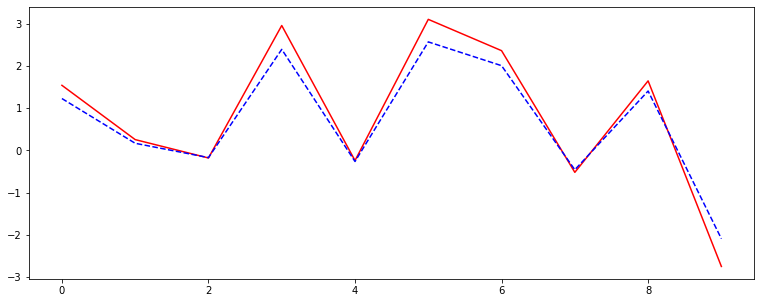

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(logistic_model.linear.bias.detach().numpy(), 'r')
ax.plot(W[-1, :], 'b--')

In [18]:
print('WEIGHT')
print('before training,', w_before_training)
print('after training,', w_after_training) 
print('initialisation : ', W[:-1,:].T)

WEIGHT
before training, Parameter containing:
tensor([[-0.0414,  0.0297,  0.0462,  ..., -0.0487,  0.0170, -0.0214],
        [ 0.0477,  0.0215, -0.0405,  ..., -0.0123, -0.0408,  0.0402],
        [ 0.0494,  0.0236,  0.0616,  ...,  0.0247,  0.0409, -0.0010],
        ...,
        [ 0.0055, -0.0033,  0.0368,  ..., -0.0208, -0.0583, -0.0591],
        [-0.0153,  0.0125,  0.0161,  ..., -0.0080,  0.0078, -0.0118],
        [ 0.0279,  0.0210, -0.0248,  ...,  0.0361,  0.0066,  0.0049]],
       requires_grad=True)
after training, Parameter containing:
tensor([[-2.2025, -1.0267,  1.0159,  ...,  0.3832,  0.6950, -0.3211],
        [ 0.0062, -0.5779, -0.3194,  ...,  0.5177,  0.5685, -1.0364],
        [-0.9313, -0.1387,  0.2665,  ...,  1.0087, -0.6167,  0.2224],
        ...,
        [ 0.2763, -2.0195, -0.9252,  ...,  0.5556,  1.9954,  0.0065],
        [-0.5265,  0.9499, -1.6943,  ..., -1.4657, -0.0408, -0.3766],
        [ 1.0836,  0.7259, -0.4251,  ..., -0.3808,  1.6480,  2.1146]],
       requires_grad=

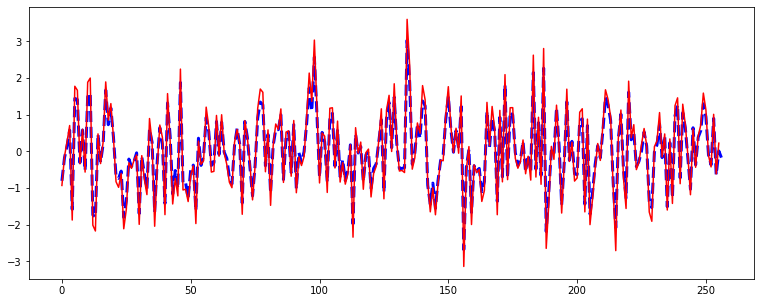

In [19]:
i_digit = 2
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(W[:, i_digit], 'b--', lw=3)
ax.plot(logistic_model.linear.weight[i_digit, :].detach().numpy(), 'r')

On voit que les biais et les poids ont changé après l'apprentissage pour se rapprocher de ceux de l'intialisation

## un modele réaliste de courbes d'accord

Text(0.5, 0, 'address')

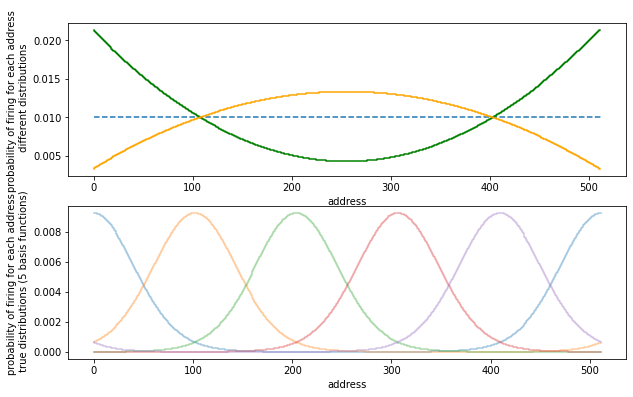

In [20]:
fig_width = 10
phi = np.sqrt(5)/2 + 1/2
N_trials = 2**11 # number of trials
p1 = .01 # average firing probability
N = 2**9 # number of addresses
K = 5 # number of patterns
sigma = .51 # bandwidth

p2 = 1. - .75*np.linspace(-1, 1, N, endpoint=True)**2
p2 /= p2.mean()
p2 *= p1
p3 = 1. + 4.*np.linspace(-1, 1, N, endpoint=True)**2
p3 /= p3.mean()
p3 *= p1
p = np.vstack((p1*np.ones(N), p2, p3)).T

# a simple circular function to generate patterns
def von_mises(j, N, sigma):
    p = np.exp( np.cos(2*np.pi* (np.linspace(0, 1, N, endpoint=False) -j/N)) / sigma**2)
    p /= p.sum()
    return p

def stack(K, N, sigma):
    p = np.zeros((N, K))
    for k in range(K):
        p[:, k] = von_mises(k*N/K, N, sigma)
    return p

p_true = stack(K, N, sigma)

N_hyp = p_true.shape[-1]
fig, ax = plt.subplots(2, 1, figsize=(fig_width, fig_width/phi))
#ax[0].step(np.arange(N), b.mean(axis=0), label='firing rate for each address')
ax[0].step(np.arange(N), p3, color = 'green', label = 'p3')
ax[0].step(np.arange(N), p2, color = 'orange', label = 'p2')
ax[0].hlines(p1, 0, N, linestyles='--', label='p1')
ax[0].set_xlabel('address')
ax[0].set_ylabel('probability of firing for each address \n different distributions')
for i_test in range(N_hyp):
    ax[1].step(np.arange(N), p_true[:, i_test], alpha=.4)
ax[1].set_ylabel('probability of firing for each address \n true distributions (5 basis functions)')
ax[1].set_xlabel('address')

In [21]:
W.shape, W.min(), W.max(), p_true.shape

((257, 10), -3.6586960825627957, 3.4414146081878902, (512, 5))

In [22]:
seed = 2402
N = 256 # nombre de valeurs de l'entrée
n_classes = 10 # nombre de classes
N_batch = 10000 # nombre d'échantillons
seed = 1973

#np.random.seed(seed)
#W = np.random.randn(N+1, n_classes) # FIXED design matrix of weights (w) according to classes
p_true = stack(n_classes, N, sigma)

In [23]:
p_true.shape

(256, 10)

In [24]:
p_true = np.vstack((p_true, 0.1*np.ones((1, n_classes))))

In [25]:
p_true.shape

(257, 10)

In [26]:
W = np.log(p_true/(1-p_true))

In [27]:
X, p, y = get_data(W, seed=seed, N_batch=N_batch)

In [28]:
X.shape, y.shape

((10000, 256), (10000, 10))

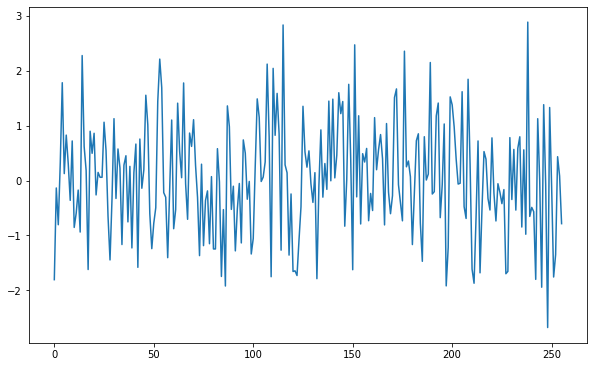

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(np.arange(N), X[0, :])

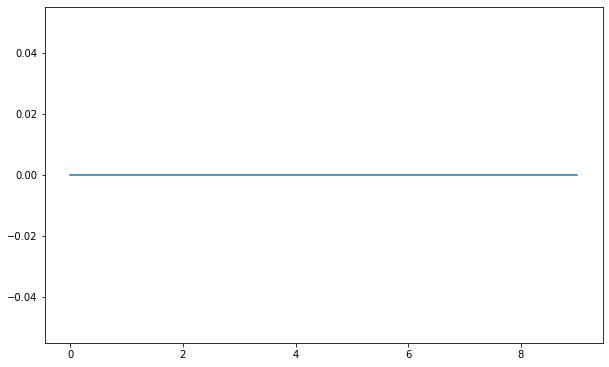

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(np.arange(n_classes), y[0, :])

In [31]:
logistic_model, loss = fit_data(X, y, verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 0.40624
Iteration: 16 - Loss: 0.07372
Iteration: 32 - Loss: 0.05477
Iteration: 48 - Loss: 0.04614
Iteration: 64 - Loss: 0.04105
Iteration: 80 - Loss: 0.03752
Iteration: 96 - Loss: 0.03483
Iteration: 112 - Loss: 0.03276
Iteration: 128 - Loss: 0.03100
Iteration: 144 - Loss: 0.02960
Iteration: 160 - Loss: 0.02835
Iteration: 176 - Loss: 0.02725
Iteration: 192 - Loss: 0.02632
Iteration: 208 - Loss: 0.02548
Iteration: 224 - Loss: 0.02474
Iteration: 240 - Loss: 0.02405
Iteration: 256 - Loss: 0.02343
Iteration: 272 - Loss: 0.02285
Iteration: 288 - Loss: 0.02233
Iteration: 304 - Loss: 0.02181
Iteration: 320 - Loss: 0.02138
Iteration: 336 - Loss: 0.02092
Iteration: 352 - Loss: 0.02053
Iteration: 368 - Loss: 0.02015
Iteration: 384 - Loss: 0.01980
Iteration: 400 - Loss: 0.01945
Iteration: 416 - Loss: 0.01917
Iteration: 432 - Loss: 0.01884
Iteration: 448 - Loss: 0.01855
Iteration: 464 - Loss: 0.01826
Iteration: 480 - Loss: 0.01802
Iteration: 496 - Loss: 0.01775
Iteration: 512 -

Text(0.5, 0, 'address')

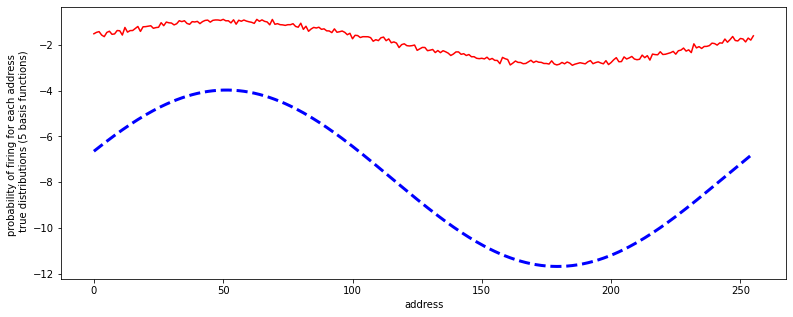

In [32]:
i_digit = 2
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(W[:-1, i_digit], 'b--', lw=3)
ax.plot(logistic_model.linear.weight[i_digit, :].detach().numpy(), 'r')
ax.set_ylabel('probability of firing for each address \n true distributions (5 basis functions)')
ax.set_xlabel('address')

Text(0.5, 0, 'address')

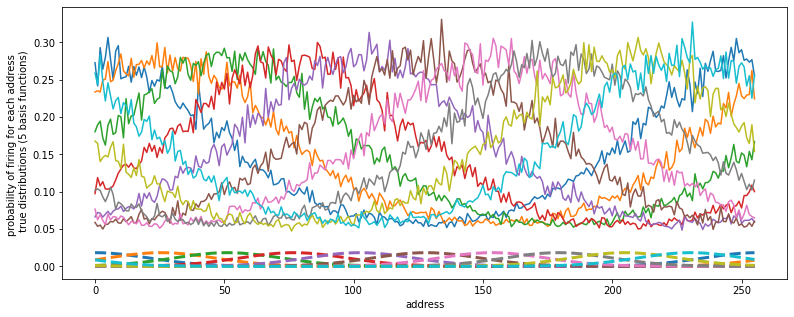

In [33]:
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(sigmoid(W[:-1, :]), '--', lw=3)
ax.plot(sigmoid(logistic_model.linear.weight[:, :].detach().numpy().T), '-')
ax.set_ylabel('probability of firing for each address \n true distributions (5 basis functions)')
ax.set_xlabel('address')

Text(0.5, 0, 'address')

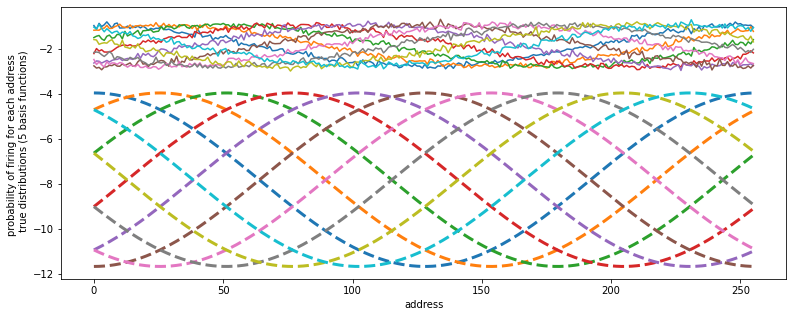

In [34]:
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(W[:-1, :], '--', lw=3)
ax.plot(logistic_model.linear.weight[:, :].detach().numpy().T, '-')
ax.set_ylabel('probability of firing for each address \n true distributions (5 basis functions)')
ax.set_xlabel('address')